In [1]:
import collections
import os

import ROOT
import matplotlib.pyplot as plt
import matplotlib.patches as patch
%matplotlib inline
import numpy as np
from tqdm import tqdm

from muhelper import helper_filereader
# import pdgid
# id_to_name, name_to_id = pdgid.get_id_data()

Welcome to JupyROOT 6.28/10


In [7]:
def extract_array(StdHep, n=4):
    if n>1:
        return np.reshape([StdHep[i] for i in range(len(StdHep))], (len(StdHep)//n, n))
    else:
        return np.array([StdHep[i] for i in range(len(StdHep))])
        
        
def get_final(Tree):
    N = Tree.StdHepN # Number of entries in this event
    fd,ld = extract_array(Tree.StdHepFd, n=1), extract_array(Tree.StdHepLd, n=1)
    inds = np.flatnonzero((fd==-1)&(ld==-1)) # find index of outgoing particle
    
    finals_p4=[]
    finals_pdg=[]
    for i in inds:
        finals_p4.append([Tree.StdHepP4[i*4+0],Tree.StdHepP4[i*4+1],Tree.StdHepP4[i*4+2],Tree.StdHepP4[i*4+3]] )
        finals_pdg.append(Tree.StdHepPdg[i])
    return finals_p4, finals_pdg

In [3]:
det_width=39 #m
det_height=15.8 #m
cut_extend=1 #m

In [4]:
folder="/project/6049244/data/MATHUSLA/simulation/run-2024-07-cosmic-neutrino/genie"
run=1
filename=f"{folder}/gntp.{run}.gtrac.root"

In [8]:
for run in range(1,11):
    filename=f"{folder}/gntp.{run}.gtrac.root"

    tfile=ROOT.TFile(filename)
    tree_name = tfile.GetListOfKeys()[0].GetName()
    Tree = tfile.Get(tree_name)
    entries = Tree.GetEntries()
    branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
    tfile.ls()
    print(entries, branches)

    # Get the filereader file ready
    filename_filereader_txt = os.path.dirname(filename)+"/filereader_"+os.path.basename(filename).replace(".root", ".txt")

    vertex_selected={}
    for i in range(entries):
        Tree.GetEntry(i)   

        # Get the vertex location
        vertex=list(Tree.EvtVtx) # (x, y, z, t) of vertex (in SI)
        x,y,z,t = vertex

        # Only select those within the detector volume plus a little edge
        if (abs(x)<det_width/2+cut_extend)  &  (abs(y)<det_width/2+cut_extend)  & (-z>-cut_extend) & (-z<det_height+cut_extend):
            # pdgs = list(Tree.StdHepPdg)
            # x4s = extract_array(Tree.StdHepX4, n=4) # (x, y, z, t) in hit nucleus rest frame (in fm)
            # p4s = extract_array(Tree.StdHepP4, n=4) # (px, py, pz, E) in LAB frame in [GeV]
            
            # Only read the final state particles in this event
            p4s, pdgs = get_final(Tree)           
            
            
            # Get event info
            evtcode=str(Tree.EvtCode).split(";") # Example: 'nu:14;tgt:1000080160;N:2112;proc:Weak[CC],QES;'
            parent_pdg=int(evtcode[0].split(":")[1])

            # add back the detector offset
            # xx,yy,zz=y*1000, (-z+85.47)*1000, (x+90)*1000 # Convert to CMS coordinate (wrong)
            xx,yy,zz=(x+90)*1000, y*1000, z*1000
            vertex_selected[i]=[[parent_pdg, xx,yy,zz, 0,0,0, 0]]
            for iparticle in range(len(p4s)):
                p4=p4s[iparticle]
                pdg=pdgs[iparticle]
                # Remove the pdgs of Nuclear codes
                if abs(pdg)<10000:
                    vertex_selected[i].append([pdg, xx,yy,zz, p4[0]*1000, p4[1]*1000, p4[2]*1000, 0])

    # Write this to a filereader txt file
    keys=list(vertex_selected.keys())
    nevents = len(keys)

    f = open(filename_filereader_txt, "w")
    f.write(f"# nevents {nevents}\n\n")

    for ikey in range(len(keys)):
        evt = vertex_selected[keys[ikey]]
        vertex = evt[0]
        particles = evt[1:]

        evt_txt = helper_filereader.make_event(ikey, particles, vertex)
        f.write(evt_txt)

    f.close()

    # Make a GEANT4 macro to run this
    sim_script_filename = helper_filereader.generate_sim_script_filereader(filename_filereader_txt)

468420 ['EvtFlags', 'EvtCode', 'EvtNum', 'EvtXSec', 'EvtDXSec', 'EvtKPS', 'EvtWght', 'EvtProb', 'EvtVtx', 'StdHepN', 'StdHepPdg', 'StdHepStatus', 'StdHepRescat', 'StdHepX4', 'StdHepP4', 'StdHepPolz', 'StdHepFd', 'StdHepLd', 'StdHepFm', 'StdHepLm']
Script saved at /project/6049244/data/MATHUSLA/simulation/run-2024-07-cosmic-neutrino/genie/filereader_gntp.1.gtrac.mac
467576 ['EvtFlags', 'EvtCode', 'EvtNum', 'EvtXSec', 'EvtDXSec', 'EvtKPS', 'EvtWght', 'EvtProb', 'EvtVtx', 'StdHepN', 'StdHepPdg', 'StdHepStatus', 'StdHepRescat', 'StdHepX4', 'StdHepP4', 'StdHepPolz', 'StdHepFd', 'StdHepLd', 'StdHepFm', 'StdHepLm']
Script saved at /project/6049244/data/MATHUSLA/simulation/run-2024-07-cosmic-neutrino/genie/filereader_gntp.2.gtrac.mac
467617 ['EvtFlags', 'EvtCode', 'EvtNum', 'EvtXSec', 'EvtDXSec', 'EvtKPS', 'EvtWght', 'EvtProb', 'EvtVtx', 'StdHepN', 'StdHepPdg', 'StdHepStatus', 'StdHepRescat', 'StdHepX4', 'StdHepP4', 'StdHepPolz', 'StdHepFd', 'StdHepLd', 'StdHepFm', 'StdHepLm']
Script saved at 

---

In [2]:
filename="gntp.5.gtrac.root"

In [7]:
tfile=ROOT.TFile(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)
entries = Tree.GetEntries()
branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
tfile.ls()
print(entries, branches)

447543 ['EvtFlags', 'EvtCode', 'EvtNum', 'EvtXSec', 'EvtDXSec', 'EvtKPS', 'EvtWght', 'EvtProb', 'EvtVtx', 'StdHepN', 'StdHepPdg', 'StdHepStatus', 'StdHepRescat', 'StdHepX4', 'StdHepP4', 'StdHepPolz', 'StdHepFd', 'StdHepLd', 'StdHepFm', 'StdHepLm']
TFile**		gntp.5.gtrac.root	
 TFile*		gntp.5.gtrac.root	
  OBJ: TTree	gRooTracker	GENIE event tree rootracker format : 0 at: 0x558299ca2920
  KEY: TTree	gRooTracker;9	GENIE event tree rootracker format [current cycle]
  KEY: TTree	gRooTracker;8	GENIE event tree rootracker format [backup cycle]


In [8]:
vertices=[]
for i in tqdm(range(entries)):
    Tree.GetEntry(i)    
    vertices.append(list(Tree.EvtVtx))
vertices=np.array(vertices)

100%|██████████| 447543/447543 [00:23<00:00, 18723.36it/s]


In [9]:
x = vertices[:,0]
y = vertices[:,1]
z = vertices[:,2]
full_det_height=15.8
det_half_width = 19.5
mask_in_det = (abs(x)<det_half_width) & (abs(y)<det_half_width) & (z<0) & (z>-full_det_height)
mask_in_volume = (abs(x)<det_half_width) & (abs(y)<det_half_width) & (z<-0.8) & (z>-full_det_height+2.4)
ext=1
mask_in_det_ext = (abs(x)<det_half_width+ext) & (abs(y)<det_half_width+ext)& (z<0+ext) & (z>-full_det_height-ext)
sum(mask_in_det),sum(mask_in_volume), sum(mask_in_det_ext)

(196, 31, 1248)

Text(0, 0.5, 'Verticle (minus is upward) [m]')

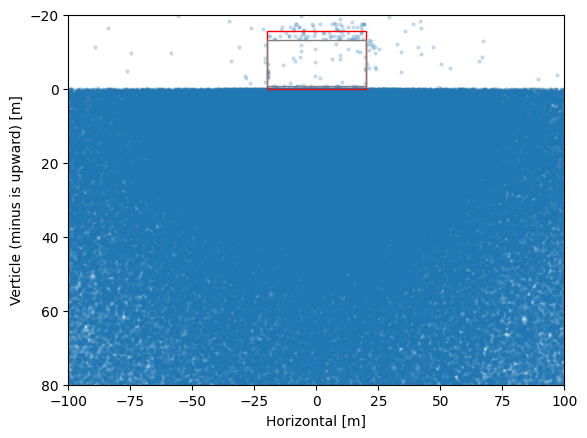

In [15]:
plt.scatter(vertices[:,0], vertices[:,2], s=4, alpha=0.2)
plt.gca().add_patch(patch.Rectangle((-20,-full_det_height), 40,full_det_height, edgecolor='r', facecolor='none'))
plt.gca().add_patch(patch.Rectangle((-20,-full_det_height+2.4), 40,full_det_height-3.2, edgecolor='grey', facecolor='none'))
plt.xlim(-100,100)
plt.ylim(-20,80)
plt.gca().invert_yaxis()
plt.axhline(0,color="grey", alpha=0.1)
plt.xlabel("Horizontal [m]")
plt.ylabel("Verticle (minus is upward) [m]")

In [5]:
p4=[]
pdgs=[]
for i in tqdm(range(entries)):
    Tree.GetEntry(i)   
    finals_p4, finals_pdg = get_final(Tree)    
    p4.extend(finals_p4)
    pdgs.extend(finals_pdg)
p4=np.array(p4)

100%|██████████| 447543/447543 [07:48<00:00, 954.52it/s] 


In [6]:
c = dict(collections.Counter(pdgs))
pdgids = list(c.keys())
counts = [c[k] for k in pdgids]
c

{11: 93040,
 2212: 788479,
 2112: 618862,
 2000000002: 444970,
 22: 120304,
 -14: 28890,
 2000000101: 106684,
 -13: 41431,
 14: 67795,
 111: 73999,
 12: 38261,
 13: 146045,
 211: 82654,
 -211: 49221,
 4212: 22,
 -12: 12296,
 2103: 1929,
 3122: 2700,
 321: 2403,
 -11: 19982,
 3112: 725,
 1000080160: 1248,
 2203: 1092,
 -321: 645,
 3212: 249,
 1000140280: 601,
 1103: 294,
 311: 1944,
 -311: 615,
 1000200400: 97,
 3222: 575,
 2101: 183,
 4122: 115,
 -3122: 14,
 4222: 54,
 -2112: 84,
 -2212: 84,
 130: 8,
 1000060120: 54,
 -421: 5,
 421: 19,
 411: 24,
 1000070140: 2,
 1000130270: 37,
 -411: 6,
 431: 2}

Text(0, 0.5, 'Counts')

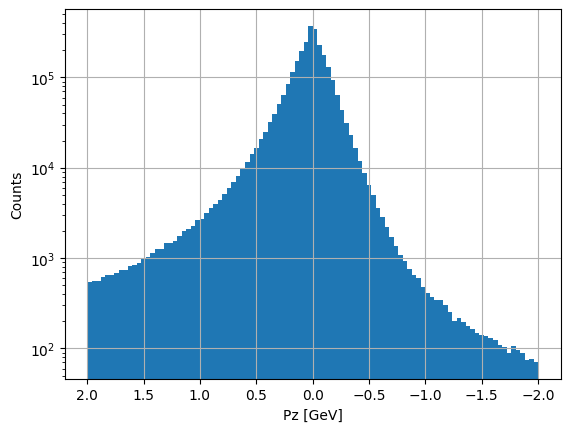

In [7]:
plt.hist(p4[:,2], bins=100, range=[-2,2]);
plt.yscale("log")
plt.gca().invert_xaxis()
plt.grid()
plt.xlabel("Pz [GeV]")
plt.ylabel("Counts")